### Building a simple rate-based recurrent neural mass network

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.integrate import ode

Model equations taken from Song et al., 2016
!["RNN Model [Song 2016]"](img/rnn_model1.png)
!["RNN Model [Song 2016]"](img/rnn_model2.png)

### the (1-alpha) in the first term comes from moving x[t-1] to the right side; ignore in the implementation
dx/dt = x[t]-x[t-1] = (dt/tau)(-x[t-1] +...)

->

x[t] = (1-(dt/tau)x[t-1] + dt/tau *...

In [2]:
def rnn_model(t, x, params):
    # because this function is only suppose to output the
    # state variable, any intermediate computations that
    # we want to keep track of should be done outside, and 
    # passed into the function via params

    # rnn_model is a neural mass model of the form:
    #    dx/dt = (dt/tau) * (-x +Wr*rate + Win*input + noise)
    #    rate can be rectified linear, 

    # neuron time constant (static)
    tau = params['tau']
    
    # input
    Win = params['Win']
    stim = params['input']
    
    # recurrent unit rates
    Wrec = params['Wrec']
    rate = params['rate']

    # noise
    noise = params['noise']
    
    dxdt = (-x+np.dot(Win, stim)+np.dot(Wrec,rate)+noise)/tau
    return dxdt

In [3]:
# Parameters specified by Abbott 2009.
def lorentz(t, X, params = {'sigma':10, 'beta':8/3, 'rho':28}):
    x,y,z = X
    sigma = params['sigma']
    beta = params['beta']
    rho = params['rho']
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

In [27]:
t_max = 40
dt = 0.001
N_input_units = 3
N_rec_units = 40
N_output_units = 1
rho = 1.2
noise_std = 1.

# computing butterfly input
stim = []
lo_solver = ode(lorentz)
lo_solver.set_initial_value(t=0, y=list(np.random.normal(size=3)))
while lo_solver.t<t_max:
    lo_solver.integrate(lo_solver.t+dt)
    stim.append(lo_solver.y)

stim = list(np.array(stim)/20)

# initialize
x_init = np.random.normal(size=N_rec_units)/10

# input weights
Win = np.random.normal(size=(N_rec_units,N_input_units))

# non-symmetric recurrent weights 
Wrec = np.random.normal(size=(N_rec_units, N_rec_units))
Wrec = Wrec*rho/np.max(np.abs(np.linalg.eigvals(Wrec))) # set spectral radius

# define constant params
params = {    
    'tau': 0.5,
    'Win': Win,
    'input' : np.zeros(N_input_units),
    'Wrec': Wrec,
    'rate': np.zeros(N_rec_units),
    'std_rec' : 0.15,
    'noise': np.zeros(N_rec_units)
}
noise_amp = np.sqrt(2.*(1/params['tau'])*params['std_rec']**2)

In [31]:
np.random.seed(42)
solver = ode(rnn_model)
solver.set_initial_value(y=x_init, t=0)

x = []
global_step = 0
while solver.t<t_max:
    # dt is the set increment, and solver.t automatically keeps track of time
    
    # define variable params
    params['noise'] = np.random.normal(size=N_rec_units)*noise_amp
    params['input'] = stim[global_step]
    params['input'] = np.zeros(N_input_units)
    # relu or tanh units
    if global_step:
        params['rate'] = (x[-1]>0)*x[-1] #ReLU
    
    # set params
    solver.set_f_params(params)    
    
    # integrate
    solver.integrate(solver.t+dt)
    
    # save out
    x.append(solver.y) # record state
    
    # increment global step
    global_step+=1
    
print(global_step)

40001


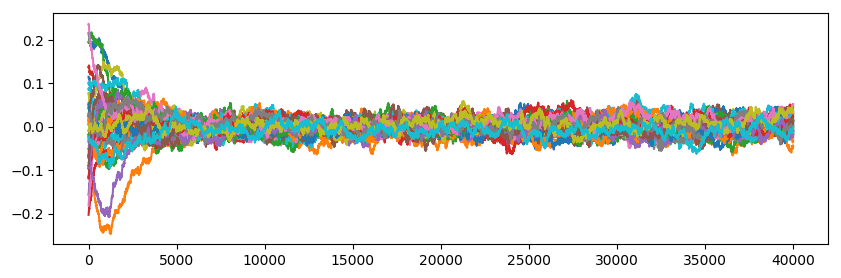

In [33]:
x = np.array(x)
plt.figure(figsize=(10,3))
plt.plot(x[:,:]);
#plt.plot(stim, 'k--')
#plt.imshow(x[5000:,:])

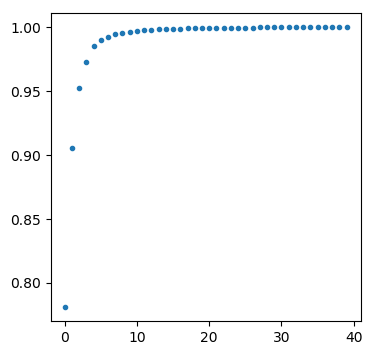

In [11]:
pca = PCA(n_components=N_rec_units)
pca.fit(x[10000:,:])
plt.plot(np.cumsum(pca.explained_variance_ratio_), '.')